# 階層モデル
計測を仕事にしてる人向けの雑なstanの使い方の例

階層モデルを使う場合の例

In [71]:
#Uncomennt to install the library  on jupyter lab (Unix etc..)
#!pip install mako
#!pip install pystan
#!pip install arviz

#windowsで試すひとはAnaconda/JupyterLabをインストールして以下のようにライブラリを追加
#On windows Anaconda
#Run following in conda terminal on windows
#conda install mako pystan arviz
#conda install libpython m2w64-toolchain -c msys2


from stan_util import get_stan_model,print_code
import numpy as np
import arviz as az
import math
import matplotlib.pyplot as plt
from scipy.special import logsumexp
def waic(log_lik):
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum() #exp.mean() means marginalization for w(parameter)
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return waic
def hwaic(log_lik):
    log_lik
def wbic(log_lik):
    
    b2= 1.0/math.log(log_lik.shape[1])
    b1= 1.0
    log_denominator =  logsumexp((b1-b2)*np.sum(-log_lik,axis=1))     #statnet.common::log_sum_exp(-(b2-b1)*(rowSums(-log_lik)))
    log_numerator   =  logsumexp((b1-b2)*(np.sum(-log_lik,axis=1) + np.log(np.sum(-log_lik,axis=1))))   #statnet.common::log_sum_exp(-(b2-b1)*(rowSums(-log_lik)) + log(rowSums(-log_lik)))
    wbic= math.exp(log_numerator - log_denominator)
    return wbic

# シミュレーションデータ
計測周りで階層モデルを使う時は、普通は多段階の工程を踏んで製造されたものを計測するする場合です。

例えば、酒を作る場合タンク毎に微妙な個性があります。それを分析計測する際には計測誤差が載ります。このような「タンク毎の個性」と「計測誤差」は単純に加算されます。

M本のタンクでN回計測する場合を考えます。計測ノイズについては二通りの考え方をしてみます
+ 計測ノイズはタンクに寄らず同じである（計測機器の問題）
+ 計測ノイズはタンク毎に違う（タンクの攪拌度合いなど、サンプリングの問題）



## シミュレーションデータ作成

tank_true [0.17835397 0.64842251 1.07328254 1.09760524 1.42799466 1.47972754
 1.7079424  1.80510156 2.05840267 2.07791948 2.19633454 2.21349608
 2.28830642 2.55310901 2.65968518 2.79996267 3.03404975 3.07382529
 3.4086247  4.22710383]


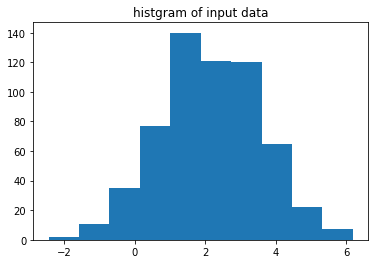

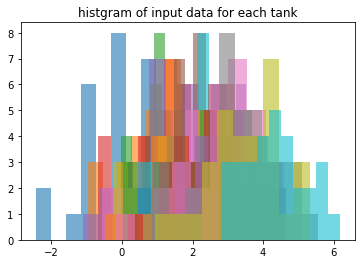

tank_noise [2.21697604e-02 2.83680877e-01 3.36351550e-02 1.14029760e+00
 2.59902017e-01 1.56186567e-02 1.91957724e-01 6.05490076e-02
 1.71834416e-01 2.55535151e-01 8.29825516e-02 7.19670956e-01
 2.90098921e-01 1.93340760e-01 8.99039169e-02 1.23895747e-01
 2.20437081e-02 3.19626310e-01 6.65921056e+00 5.18142569e-03]


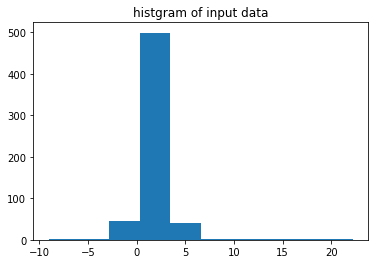

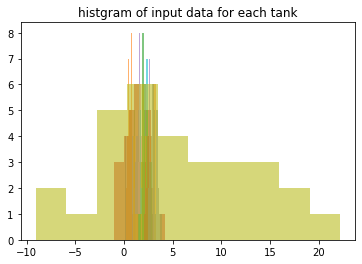

In [86]:
#タンクによらず計測ノイズ一定
M=20
N=30
Y=np.empty((M,N),np.float)
tank_true=np.random.randn(M)*1+2 #タンクの真値(個性)を乱数で生成
tank_true=np.sort(tank_true) #結果を見やすくするためにソート
print("tank_true",tank_true)
for m in range(M):
    Y[m,:]=tank_true[m]+np.random.randn(N)*1 #計測誤差を載せる

plt.title("histgram of input data")
plt.hist(Y.reshape(-1))
plt.show()
plt.title("histgram of input data for each tank")
for i in range(Y.shape[0]):
    plt.hist(Y[i,:], bins=10,alpha=0.6,histtype='stepfilled')
plt.show()

Y2=np.empty((M,N),np.float)
tank_noise=np.exp(np.random.randn(M)*+2)/np.exp([2]) #タンクのノイズ
print("tank_noise",tank_noise)
for m in range(M):
    Y2[m,:]=tank_true[m]+np.random.randn(N)*tank_noise[m] #計測誤差を載せる

plt.title("histgram of input data")
plt.hist(Y2.reshape(-1))
plt.show()
plt.title("histgram of input data for each tank")
for i in range(Y2.shape[0]):
    plt.hist(Y2[i,:], bins=10,alpha=0.6,histtype='stepfilled')
plt.show()




INFO:pystan:COMPILING THE C++ CODE FOR MODEL hie_static_578b6b263588a476704649d1c4fb8285 NOW.


1 data{
2     int M;
3     int N;
4     vector[N] Y[M];
5 }
6 parameters{
7     vector[M] tank;
8     real tank_u;
9     real tank_s;
10     real sigma;
11 }
12 model{
13     tank ~ normal(tank_u,tank_s);
14     for(m in 1:M){
15         Y[m] ~ normal(tank[m],sigma);
16     }
17 }
18 generated quantities{
19     vector[N] log_likelihood[M];
20     for(m in 1:M){for(n in 1:N){
21         log_likelihood[m,n] = normal_lpdf(Y[m,n] | normal_rng(tank_u,tank_s),sigma);
22     }}
23 }
24 
Inference for Stan model: hie_static_578b6b263588a476704649d1c4fb8285.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma      1.03  4.7e-4   0.03   0.97   1.01   1.03   1.05   1.09   4353    1.0
tank[1]    0.04  3.4e-3   0.19  -0.33  -0.09   0.04   0.16   0.41   3096    1.0
tank[2]    0.92  3.0e-3   0.18   0.57    0.8   0.92   1.04   1.28   3642    1.0
tank[3

D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:189: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  UserWarning,


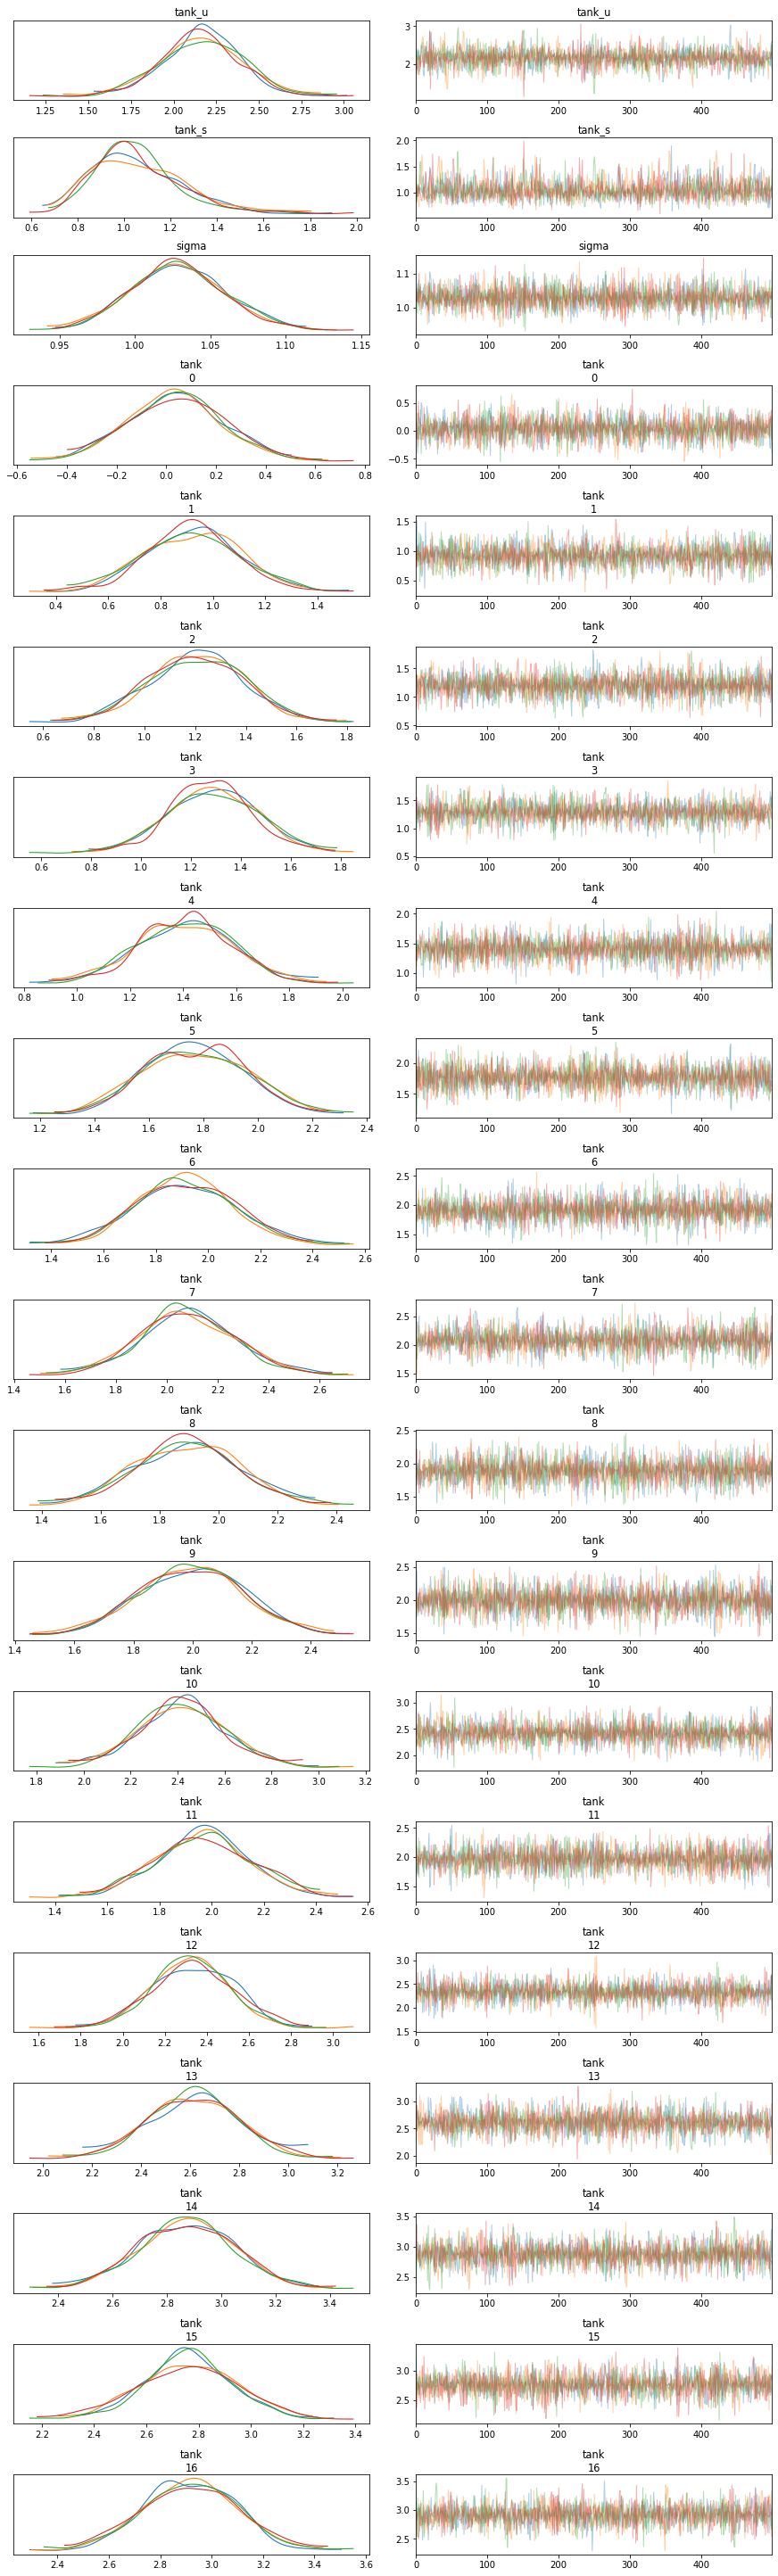

WAIC: 5680.172533280935
WBIC: 796.0009695925417


In [87]:


model=get_stan_model("hie_static")
print_code(model)
stan_data={
        "M":M,
        "N":N,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["log_likelihood"]))))

#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("tank_u","tank_s","sigma","tank"))
plt.show()
#visualize

ll=fit.extract('log_likelihood')['log_likelihood'].reshape(ll.shape[0],-1)
print("WAIC:",waic( ll ))
print("WBIC:",wbic( ll ))



INFO:pystan:COMPILING THE C++ CODE FOR MODEL hie_static2_183ccc9590c5c3dcd221362e701b4eee NOW.


1 data{
2     int M;
3     int N;
4     vector[N] Y[M];
5 }
6 parameters{
7     vector[M] tank;
8     vector<lower=0>[M] tank_noise;
9     real tank_u;
10     real<lower=0> tank_s;
11     real tank_noise_u;
12     real<lower=0> tank_noise_s;
13 }
14 model{
15     tank_u ~ normal(2,5);
16     tank_s ~ normal(0,5);
17     tank_noise_u ~ normal(0,5);
18     tank_noise_s ~ normal(0,5);
19     
20     tank ~ normal(tank_u,tank_s);
21     tank_noise ~ normal(tank_noise_u,tank_noise_s);
22     for(m in 1:M){
23         Y[m] ~ normal(tank[m],tank_noise[m]);
24     }
25 }
26 generated quantities{
27     vector[N] log_likelihood;
28     real<lower=0> g_tank_noise;
29     for(m in 1:M){for(n in 1:N){
30         g_tank_noise=normal_rng(tank_noise_u,tank_noise_s);
31         log_likelihood[m] = normal_lpdf(Y[m,n] | normal_rng(tank_u,tank_s),abs(g_tank_noise));
32     }}
33 }
34 


D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:189: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (44), generating only 20 plots
  UserWarning,


Inference for Stan model: hie_static2_183ccc9590c5c3dcd221362e701b4eee.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tank[1]          0.05  9.5e-3   0.19  -0.33  -0.09   0.05   0.17   0.43    415   1.02
tank[2]          0.91    0.01    0.2   0.52   0.77   0.91   1.05   1.31    288   1.02
tank[3]          1.19  6.4e-3   0.18   0.81   1.08   1.18   1.31   1.57    823    1.0
tank[4]          1.28  8.3e-3   0.19   0.88   1.17   1.29    1.4   1.66    529   1.01
tank[5]          1.41  4.2e-3   0.18   1.04   1.29   1.42   1.53   1.78   1884    1.0
tank[6]          1.77    0.01   0.19   1.41   1.64   1.77    1.9   2.14    315   1.01
tank[7]          1.92  8.2e-3   0.18   1.56    1.8   1.93   2.04   2.25    492   1.01
tank[8]          2.09  9.4e-3   0.19   1.74   1.97   2.09   2.22   2.46    391   1.01
tank[9]          1.91  8.8e-3   0.19 

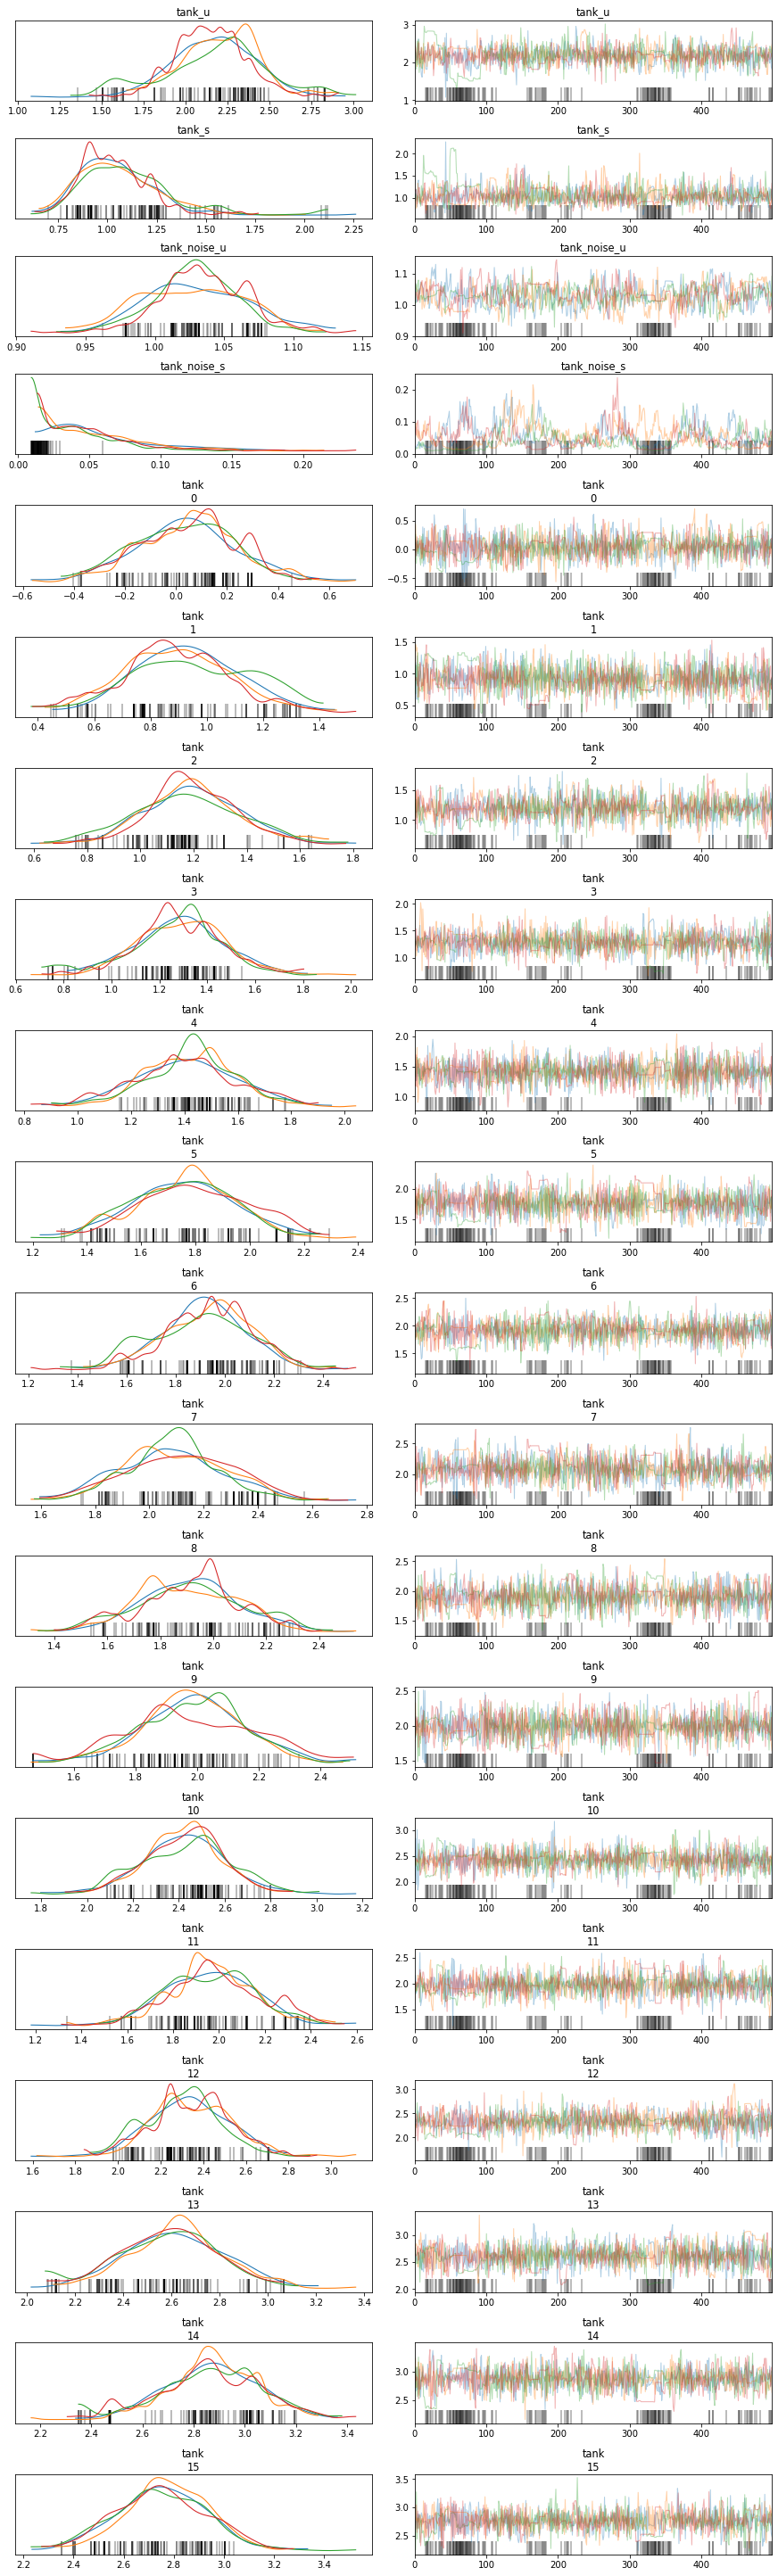

WAIC: nan
WBIC: nan


In [91]:
model=get_stan_model("hie_static2")
print_code(model)
stan_data={
        "M":M,
        "N":N,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["log_likelihood"]))))

#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("tank_u","tank_s","tank_noise_u","tank_noise_s","tank","tank_noise"))
plt.show()
#visualize

ll=fit.extract('log_likelihood')['log_likelihood'].reshape(ll.shape[0],-1)
print("WAIC:",waic( ll ))
print("WBIC:",wbic( ll ))


1 data{
2     int M;
3     int N;
4     vector[N] Y[M];
5 }
6 parameters{
7     vector[M] tank;
8     real tank_u;
9     real tank_s;
10     real sigma;
11 }
12 model{
13     tank ~ normal(tank_u,tank_s);
14     for(m in 1:M){
15         Y[m] ~ normal(tank[m],sigma);
16     }
17 }
18 generated quantities{
19     vector[N] log_likelihood[M];
20     for(m in 1:M){for(n in 1:N){
21         log_likelihood[m,n] = normal_lpdf(Y[m,n] | normal_rng(tank_u,tank_s),sigma);
22     }}
23 }
24 
Inference for Stan model: hie_static_578b6b263588a476704649d1c4fb8285.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma      1.78  1.0e-3   0.05   1.68   1.74   1.78   1.81   1.88   2686    1.0
tank[1]    0.33  6.2e-3   0.32  -0.29   0.11   0.34   0.54   0.93   2606    1.0
tank[2]    0.77  6.2e-3   0.31   0.16   0.55   0.77   0.98   1.36   2525    1.0
tank[3

D:\Users\akira\Anaconda3\envs\stan\lib\site-packages\arviz\plots\traceplot.py:189: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  UserWarning,


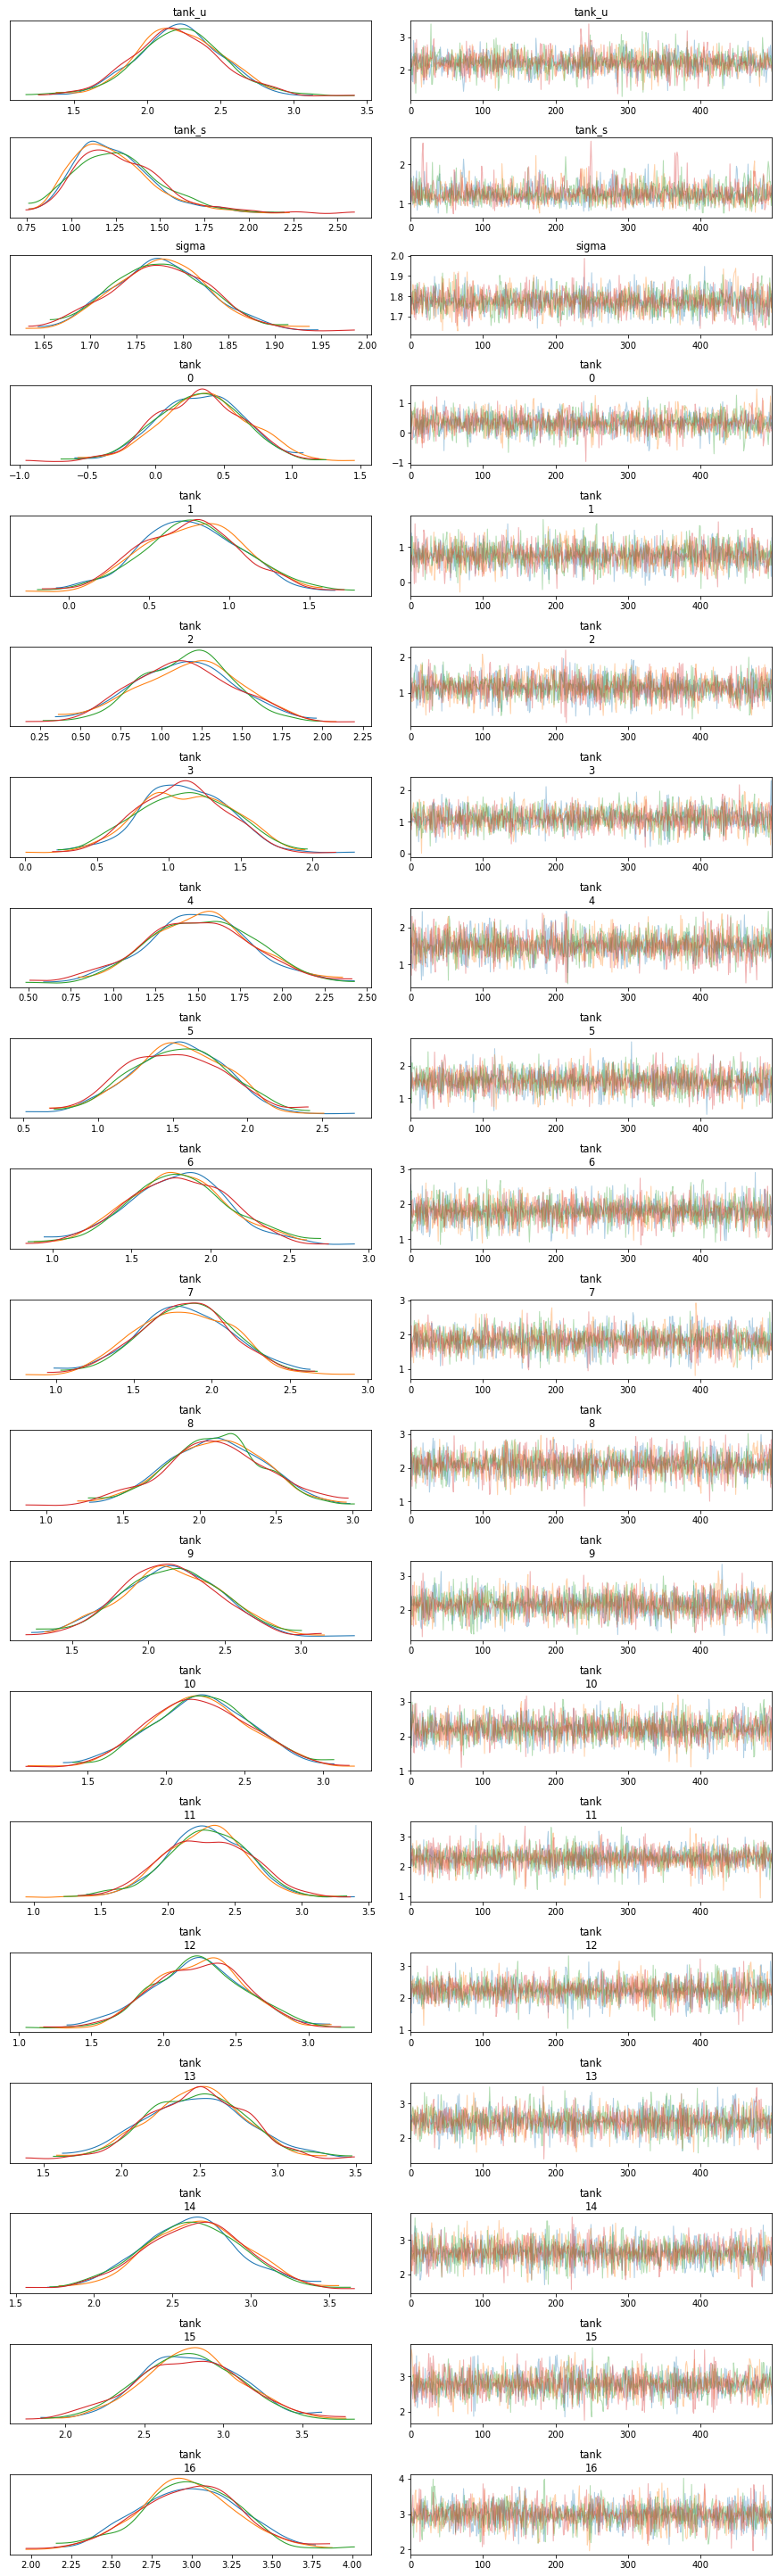

WAIC: 3847.543393635362
WBIC: 660.7329881173299


In [92]:
model=get_stan_model("hie_static")
print_code(model)
stan_data={
        "M":M,
        "N":N,
        "Y":Y2,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
#以下は結果の出力
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["log_likelihood"]))))
#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("tank_u","tank_s","sigma","tank"))
plt.show()
ll=fit.extract('log_likelihood')['log_likelihood'].reshape(ll.shape[0],-1)
print("WAIC:",waic( ll ))
print("WBIC:",wbic( ll ))

In [ ]:
model=get_stan_model("hie_static2")
print_code(model)
stan_data={
        "M":M,
        "N":N,
        "Y":Y2,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["log_likelihood"]))))

#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("tank_u","tank_s","tank_noise_u","tank_noise_s","tank","tank_noise"))
plt.show()
#visualize

ll=fit.extract('log_likelihood')['log_likelihood'].reshape(ll.shape[0],-1)
print("WAIC:",waic( ll ))
print("WBIC:",wbic( ll ))
